### Experiments on bikeability curve

Goals

- Build out pipeline to efficiently generate coarsened graph
- Define set of metrics to describe LSOA using bike curve
- Select a random x numnber of LSOAs
- Generate route choice vars and test against cycling uptake

In [1]:
import psycopg2
import pyproj
import geopandas as gpd
import pandas as pd
import random
from shapely.geometry import box, Point
from shapely import wkt
from functools import partial
from shapely.ops import transform
from shapely.ops import split
import ast
from shapely import to_geojson
from geojson_length import calculate_distance, Unit
import networkx as nx
from itertools import product
import heapq
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
from pyproj import Geod
import math
import numpy as np
from scipy.spatial import ConvexHull
import pickle

In [2]:
bbx_expansion = 0.5

#Below function from ChatGPT
#Get expanded network - method 1 km buffer
def expand_bbox(original_bbox, expansion_distance_km=5):
    # Create a Shapely geometry object for the original bounding box
    original_geometry = box(*original_bbox)
    # Define a function to project the geometry to a new coordinate reference system
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),  # WGS 84 coordinate reference system
        pyproj.Proj(proj='utm', zone=33, ellps='WGS84')  # Example: UTM Zone 33
    )
    # Project the original geometry to the new coordinate reference system
    projected_geometry = transform(project, original_geometry)
    # Calculate the expansion distance in the projected coordinate system
    expansion_distance_meters = expansion_distance_km * 1000
    # Expand the geometry by the specified distance
    expanded_geometry = projected_geometry.buffer(expansion_distance_meters)
    # Project the expanded geometry back to the original coordinate reference system
    expanded_geometry = transform(partial(pyproj.transform, pyproj.Proj(proj='utm', zone=33, ellps='WGS84'), pyproj.Proj(init='epsg:4326')), expanded_geometry)
    # Get the coordinates of the expanded bounding box
    expanded_bbox = expanded_geometry.bounds
    return expanded_bbox, expanded_geometry

def create_bounding_box(geometry1, geometry2):

    # Calculate the union of all polygons in each multipolygon
    union_geometry1 = geometry1.convex_hull
    union_geometry2 = geometry2.convex_hull
    # Calculate the union of the convex hulls of the two multipolygons
    union_geometry = union_geometry1.union(union_geometry2)
    # Get the bounding box of the union geometry
    bounding_box = union_geometry.bounds
    return bounding_box

def get_edges_from_geom(geom, con, project, table):
    
    # Define your query with a placeholder for the polygon WKT
    query = """
    SELECT r.*, ST_AsText(r.geometry) as geom_str
    FROM import.{} as r
    WHERE ST_Intersects(r.geometry, ST_GeomFromText(%s, 3857));
    """.format(table)
    
    # Execute the query
    with con.cursor() as cursor:
        cursor.execute(query, (transform(project.transform, geom).wkt,))
        results = cursor.fetchall()
        # Get column names
        colnames = [desc[0] for desc in cursor.description]
        
    # Convert results to a DataFrame
    expanded_edges = pd.DataFrame(results, columns=colnames)
    
    # Convert the geometry column to Shapely geometries
    expanded_edges['geometry'] = expanded_edges['geom_str'].apply(wkt.loads)
    
    # Return as a GeoDataFrame
    return gpd.GeoDataFrame(expanded_edges, geometry='geometry').set_crs(3857).to_crs(4326)

def get_dist_metres(line):
    new_dict = {}
    new_dict['geometry'] = ast.literal_eval(to_geojson(line))
    return calculate_distance(new_dict, Unit.meters)

def create_graph(osm_edges):

    #Node Tracking
    seen_coords = set()
    junctions = set()
    coords_to_edges = {}
    coords_ids = {}
    c_id = 0

    #Edge Tracking
    edges_dict = {}
    edge_id = 0

    count_its = 0


    for i,r in osm_edges.iterrows():
        #Get geom points
        #Get length of geom
        count_its += 1
        
        edge_coords = list(r['geometry'].coords)
        num_geoms = len(edge_coords)
        
        u = edge_coords[0]
        remaining_length = r['length']
        remaining_geom = r['geometry']
        edge_index = 1
        
        for coord in edge_coords:    
            dist_to_start = edge_index - 1
            dist_to_end = num_geoms - edge_index
            num_coords_in_geom = edge_coords.count(coord)
            
            #If coord is an existing junction in system
            if coord in junctions:
                
                #Check if junction along current edge
                if (dist_to_start > 0) & (dist_to_end > 0) & (num_coords_in_geom == 1):
                    #Split edge
                    split_geom = split(remaining_geom,Point(coord))
                    geom0_prop = get_dist_metres(split_geom.geoms[0]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    geom1_prop = get_dist_metres(split_geom.geoms[1]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    length_geom0 = geom0_prop * remaining_length
                    length_geom1 = geom1_prop * remaining_length
                
                    #Add first part of edge to edges
                    v = coord
                    edge_features = {}
                    edge_features['source'] = coords_ids[u]
                    edge_features['destination'] = coords_ids[v]
                    edge_features['length'] = length_geom0
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[0]
                    edges_dict[edge_id] = edge_features
                    edge_id = max(edges_dict.keys()) + 1
                    
                    #Update tracking matrices for remaining part of edge
                    u = v
                    remaining_length = length_geom1
                    remaining_geom = split_geom.geoms[1]
                
            #First time seeing a repeated coord which is not in self same edge - class this as a junction  
            elif (coord in seen_coords) & (num_coords_in_geom == 1):
                
                #Add node to junctions
                junctions.add(coord)
                
                #Check if intersection
                if (dist_to_start > 0) & (dist_to_end > 0):
                    #Split edge
                    split_geom = split(remaining_geom,Point(coord))
                    geom0_prop = get_dist_metres(split_geom.geoms[0]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    geom1_prop = get_dist_metres(split_geom.geoms[1]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    length_geom0 = geom0_prop * remaining_length
                    length_geom1 = geom1_prop * remaining_length
                        
                    v = coord
                    edge_features = {}
                    edge_features['source'] = coords_ids[u]
                    edge_features['destination'] = coords_ids[v]
                    edge_features['length'] = length_geom0
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[0]
                    edges_dict[edge_id] = edge_features
                    edge_id = max(edges_dict.keys()) + 1
                    
                    #Update tracking matrices for remaining part of edge
                    u = v
                    remaining_length = length_geom1
                    remaining_geom = split_geom.geoms[1]
                
                
                #Retrieve original edge and split if junction
                original_edge_id = coords_to_edges[coord]
                original_edge_dict = edges_dict[original_edge_id]
                geom_to_split_coords = list(original_edge_dict['geometry'].coords)
                coord_from_start = geom_to_split_coords.index(coord)
                coord_from_end = len(geom_to_split_coords) - geom_to_split_coords.index(coord) - 1
                num_coords_in_geom_temp = geom_to_split_coords.count(coord)
            
                if (coord_from_start > 0) & (coord_from_end > 0) & (num_coords_in_geom_temp == 1):
                    
                    split_geom = split(original_edge_dict['geometry'],Point(coord))
                    geom0_prop = get_dist_metres(split_geom.geoms[0]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    geom1_prop = get_dist_metres(split_geom.geoms[1]) / (get_dist_metres(split_geom.geoms[0]) + get_dist_metres(split_geom.geoms[1]))
                    length_geom0 = geom0_prop * original_edge_dict['length']
                    length_geom1 = geom1_prop * original_edge_dict['length']
                    
                    temp_id1 = max(edges_dict.keys()) + 2
                    temp_id2 = max(edges_dict.keys()) + 3
                    
                    #Add edge 1
                    u_temp = geom_to_split_coords[0]
                    v_temp = coord                    
                    edge_features = {}
                    edge_features['source'] = coords_ids[u_temp]
                    edge_features['destination'] = coords_ids[v_temp]
                    edge_features['length'] = length_geom0
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[0]
                    edges_dict[temp_id1] = edge_features
                    
                    #Update coord references in geom
                    for c in list(split_geom.geoms[0].coords):
                        coords_to_edges[c] = temp_id1
                    
                    
                    
                    #Add edge 2
                    u_temp = coord
                    v_temp = geom_to_split_coords[-1]
                    edge_features = {}
                    edge_features['source'] = coords_ids[u_temp]
                    edge_features['destination'] = coords_ids[v_temp]
                    edge_features['length'] = length_geom1
                    edge_features['oneway'] = r['oneway']
                    edge_features['lts'] = r['lts']
                    edge_features['geometry'] = split_geom.geoms[1]
                    edges_dict[temp_id2] = edge_features

                    #Update coord references in geom
                    
                    for c in list(split_geom.geoms[1].coords):
                        coords_to_edges[c] = temp_id2
                    
                    #Delete original edge
                    del edges_dict[original_edge_id]

            else:
                seen_coords.add(coord)
                coords_to_edges[coord] = edge_id
                coords_ids[coord] = c_id
                c_id += 1
            
            edge_index += 1
        
        #Add remaining edge   
        v = coord
        edge_features = {}
        edge_features['source'] = coords_ids[u]
        edge_features['destination'] = coords_ids[v]
        edge_features['length'] = remaining_length
        edge_features['oneway'] = r['oneway']
        edge_features['lts'] = r['lts']
        edge_features['geometry'] = remaining_geom
        edges_dict[edge_id] = edge_features
        edge_id = max(edges_dict.keys()) + 1
        
    # Construct network

    all_edges = pd.DataFrame(edges_dict).T

    # Initialize an empty directed graph
    G = nx.DiGraph()

    # Iterate over the rows of the DataFrame and add edges to the graph
    for index, row in all_edges.iterrows():
        G.add_node(row['source'], pos=(row['geometry'].coords[0]))
        G.add_node(row['destination'], pos=(row['geometry'].coords[-1]))
        G.add_edge(row['source'], row['destination'], length=row['length'], lts = row['lts'])
        # If the edge is not one-way, add the reverse edge too
        if row['oneway'] == 0:
            G.add_edge(row['destination'], row['source'], length=row['length'], lts = row['lts'])
    

    # Extract nodes with their coordinates
    nodes_data = {
        'node': [],
        'latitude': [],
        'longitude': []
    }

    for node, data in G.nodes(data=True):
        nodes_data['node'].append(node)
        nodes_data['latitude'].append(data['pos'][0])
        nodes_data['longitude'].append(data['pos'][1])

    
    return G,pd.DataFrame(nodes_data),all_edges

def sample_data(data, min_sample, rate=0.1):
    """
    Samples data from the input set based on a variable sampling rate.
    
    Parameters:
    data (list): The input dataset.
    rate (float): The sampling rate for datasets larger than 10.
    
    Returns:
    list: The sampled data.
    """
    set_size = len(data)
    
    if set_size <= min_sample:
        # If the set size is 10 or less, return the entire set
        return data
    else:
        # Calculate the sample size
        sample_size = max(min_sample, int(set_size * rate))
        
        # Sample the data
        sampled_data = random.sample(data, sample_size)
        return sampled_data
    
def mean_of_list(lst):
    return sum(lst)/len(lst)

def sample_dataframe(df, min_samples ,rate=0.1):
    """
    Samples rows from the input DataFrame based on a variable sampling rate.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    rate (float): The sampling rate for DataFrames with more than 10 rows.
    
    Returns:
    pd.DataFrame: The sampled DataFrame.
    """
    num_rows = len(df)
    
    if num_rows <= min_samples:
        # If the number of rows is 10 or less, return the entire DataFrame
        return df
    else:
        # Calculate the sample size
        sample_size = max(min_samples, int(num_rows * rate))
        
        # Sample the DataFrame
        sampled_df = df.sample(n=sample_size, random_state=1)
        return sampled_df
    
def coarsen_network(od_bbox,base_graph,base_graph_nodes,oas,oa_centroids):
    od_polygon = gpd.GeoSeries([od_bbox])
    oas_in_area = oa_centroids[oa_centroids.intersects(od_polygon.unary_union)]
    
    # Network nodes as points
    network_node_points_list = []
    for i,r in base_graph_nodes.iterrows():
        network_node_points_list.append(Point([r['latitude'],r['longitude']]))
        
    network_node_points = gpd.GeoDataFrame(geometry=network_node_points_list)

    base_graph_nodes['geometry'] = network_node_points_list
    base_graph_nodes = gpd.GeoDataFrame(base_graph_nodes, geometry = 'geometry')
    
    area_to_nodes = {}
    num_nodes_per_oa = []
    for oa in list(oas_in_area.index):
        oa_geom = gpd.GeoSeries([oas.loc[oa]['geometry']])
        oa_nodes = base_graph_nodes[base_graph_nodes.intersects(oa_geom.unary_union)]
        area_to_nodes[oa] = oa_nodes
        num_nodes_per_oa.append(len(oa_nodes))
        
    #LTS1
    lts_1_edges = [(u, v, d) for u, v, d in base_graph.edges(data=True) if d.get('lts', 0) <= 1]
    G_lts1 = nx.Graph()
    G_lts1.add_nodes_from(list(base_graph.nodes))
    G_lts1.add_edges_from(lts_1_edges)

    #LTS2
    lts_2_edges = [(u, v, d) for u, v, d in base_graph.edges(data=True) if d.get('lts', 0) <= 2]
    G_lts2 = nx.Graph()
    G_lts2.add_nodes_from(list(base_graph.nodes))
    G_lts2.add_edges_from(lts_2_edges)

    #LTS3
    lts_3_edges = [(u, v, d) for u, v, d in base_graph.edges(data=True) if d.get('lts', 0) <= 3]
    G_lts3 = nx.Graph()
    G_lts3.add_nodes_from(list(base_graph.nodes))
    G_lts3.add_edges_from(lts_3_edges)

    #LTS4
    lts_4_edges = [(u, v, d) for u, v, d in base_graph.edges(data=True) if d.get('lts', 0) <= 4]
    G_lts4 = nx.Graph()
    G_lts4.add_nodes_from(list(base_graph.nodes))
    G_lts4.add_edges_from(lts_4_edges)
    
    oas_in_area_list = list(oas_in_area.index)
    
    paths_lts_1 = {}
    paths_lts_2 = {}
    paths_lts_3 = {}
    paths_lts_4 = {}

    for o in oas_in_area_list:
        paths_lts_1[o] = {}
        paths_lts_2[o] = {}
        paths_lts_3[o] = {}
        paths_lts_4[o] = {}
        for d in oas_in_area_list:
            paths_lts_1[o][d] = []
            paths_lts_2[o][d] = []
            paths_lts_3[o][d] = []
            paths_lts_4[o][d] = []

    # Define the original layers as MultiGraphs

    for o in oas_in_area_list:
        origin_nodes = sample_dataframe(area_to_nodes[o],4,0.1)
        for next_o_node in list(origin_nodes['node']):

            all_sp_lts1 = nx.single_source_dijkstra_path_length(G_lts1,next_o_node, weight = 'length')
            all_sp_lts2 = nx.single_source_dijkstra_path_length(G_lts2,next_o_node, weight = 'length')
            all_sp_lts3 = nx.single_source_dijkstra_path_length(G_lts3,next_o_node, weight = 'length')
            all_sp_lts4 = nx.single_source_dijkstra_path_length(G_lts4,next_o_node, weight = 'length')

            for d in oas_in_area_list:
                destination_nodes = list(area_to_nodes[d]['node'])

                #Add LTS 1 Routes to Dict
                paths_to_dest = {key: all_sp_lts1[key] for key in destination_nodes if key in all_sp_lts1}
                #Remove 0 elements
                paths_to_dest = [element for element in list(paths_to_dest.values()) if element != 0]
                #Add found routes to dictionary
                paths_lts_1[o][d].extend(paths_to_dest)

                #Add LTS 2 Routes to Dict
                paths_to_dest = {key: all_sp_lts2[key] for key in destination_nodes if key in all_sp_lts2}
                #Remove 0 elements
                paths_to_dest = [element for element in list(paths_to_dest.values()) if element != 0]
                #Add found routes to dictionary
                paths_lts_2[o][d].extend(paths_to_dest)
                
                #Add LTS 3 Routes to Dict
                paths_to_dest = {key: all_sp_lts3[key] for key in destination_nodes if key in all_sp_lts3}
                #Remove 0 elements
                paths_to_dest = [element for element in list(paths_to_dest.values()) if element != 0]
                #Add found routes to dictionary
                paths_lts_3[o][d].extend(paths_to_dest)
                
                #Add LTS 4 Routes to Dict
                paths_to_dest = {key: all_sp_lts4[key] for key in destination_nodes if key in all_sp_lts4}
                #Remove 0 elements
                paths_to_dest = [element for element in list(paths_to_dest.values()) if element != 0]
                #Add found routes to dictionary
                paths_lts_4[o][d].extend(paths_to_dest)
                
            
    G_c = nx.DiGraph()
    G_c.add_nodes_from(oas_in_area_list)

    for o in oas_in_area_list:
        for d in oas_in_area_list:
            distances = []
            if len(paths_lts_1[o][d]) > 0:
                distances.append(mean_of_list(paths_lts_1[o][d]))
            else:
                distances.append(0)

            if len(paths_lts_2[o][d]) > 0:
                distances.append(mean_of_list(paths_lts_2[o][d]))
            else:
                distances.append(0)

            if len(paths_lts_3[o][d]) > 0:
                distances.append(mean_of_list(paths_lts_3[o][d]))
            else:
                distances.append(0)
                
            if len(paths_lts_4[o][d]) > 0:
                distances.append(mean_of_list(paths_lts_4[o][d]))
            else:
                distances.append(0)
            
            if sum(distances) > 0:
                G_c.add_edge(o, d, distance=distances)

    return G_c, oas_in_area_list


def assign_weights(J,types):
    #------------------------------------------#
    #input: network with 'distance' attribute and type of risk function to apply
    # output: netowrk with 'distance' and 'risk' attribute
    # assigns risk (or discomfort) attribute to each edge of the network
    # risk is a quadruple of values, just like distance, one relative to each 'street-layer' considered 
    #------------------------------------------#
    if types=='Linear':
        for edge in J.edges:
            beta = [None]*4
            beta[0] = J[edge[0]][edge[1]]['distance'][0]
            beta[1] = J[edge[0]][edge[1]]['distance'][1]*0.66
            beta[2] = J[edge[0]][edge[1]]['distance'][2]*0.33
            beta[3] = 0
            J[edge[0]][edge[1]]['risk'] = beta
    return J

def updateParetoFront(new_length, new_risk, best_length_risk_states):
    #------------------------------------------#
    # Input:  dist [int], risk[int], paretoFront [sorted dictionary]
    #output:[bolean] if the new_length and new_dist have been added to the ParetoFront returns True, False otherwise 
    # adds new dist, and new risk if the path is pareto optimal (non dominated) 
    #------------------------------------------#
    
    # Find before and after points on length-axis of relation
    after_idx = best_length_risk_states.bisect_right( new_length );
    before_idx = after_idx - 1;
    after_risk = -1
    before_risk = -1 
    
    # Find associated risks
    keys = best_length_risk_states.keys()
    if after_idx < len(best_length_risk_states):
        after_risk = best_length_risk_states.get(keys[after_idx])
    if before_idx >= 0:
        before_risk = best_length_risk_states.get(keys[before_idx])
       
    # Exclude new path if the shorter path has same or less risk
    if before_risk <= new_risk and not before_risk == -1:
        return False

    # Exclude longer or equal paths with higher risks:
    final_exclude_idx = after_idx
    while(final_exclude_idx < len(best_length_risk_states)):
        risk = best_length_risk_states.get(keys[final_exclude_idx])
        if risk < new_risk:
            break
        final_exclude_idx = final_exclude_idx + 1
    del best_length_risk_states.keys()[after_idx:final_exclude_idx]
    best_length_risk_states[new_length] = new_risk
    
    return True

def compute_pareto_fronts(J, o):
    #------------------------------------------#
    #input:  aggregated network [networkx graph], node [int]
    #output: dictionary of all pareto fronts from node 'o' to all other nodes in the network [dictionary] 
    #this implements the multi-objective optimization criteria on all possible OD pairs from node 'o' to all 
    #other nodes of the network (thus it computes ParetoFronts based on distance and risk criteria)
    #------------------------------------------#

    states_to_explore = []
    best_length_risk_states_for_node = {o : SortedDict({0: 0})}
    
    states_to_explore = []
    cnt = 0
    heapq.heappush(states_to_explore, (0, 0, cnt, { 'distance': 0, 'risk': 0, 'prevstate': None, 'node': o }))
    
    while len(states_to_explore) > 0:
        current_distance, current_risk, dummy, current_state = heapq.heappop(states_to_explore)
        current_node = current_state.get('node')
        
        # Check if the explored path is still part of the optimal length risk curve.
        # Otherwise, discard.        
        best_length_risk_states = best_length_risk_states_for_node.get(current_node)
        if best_length_risk_states.get(current_distance, -1) != current_risk:
            continue
        
        for tt in J.out_edges(current_node):
            next_node = tt[1]
            edge = J[current_state.get('node')][next_node]
            
            best_length_risk_states = best_length_risk_states_for_node.get(next_node, None)
            if best_length_risk_states is None:
                best_length_risk_states = SortedDict()
                best_length_risk_states_for_node[next_node] = best_length_risk_states
            
            # Loop over different network choices for link
            for network_i in range(len(edge['distance'])):
                
                # Compute new length
                edge_length = edge['distance'][network_i]
                if edge_length == 0:
                    continue
                new_length = current_distance + edge_length
                
                # Compute new risk
                edge_risk = edge['risk'][network_i]
                new_risk = current_risk + edge_risk
                
                inserted = updateParetoFront(new_length, new_risk, best_length_risk_states)
                if not inserted:
                    continue
                
                new_state = { 'distance': new_length, 'risk': new_risk, 'prevstate': current_state, 'node': next_node}
                # Remove removed states from states_to_explore
                
                heapq.heappush(states_to_explore, (new_length, new_risk, cnt, new_state))
                cnt = cnt + 1
                
    return best_length_risk_states_for_node

def dict_to_array(dict):
    # Convert dictionary to list of lists (each key-value pair becomes a list)
    data_list = [[key, value] for key, value in dict.items()]

    # Convert list of lists to a 2D NumPy array
    return np.array(data_list)

def haversine_distance(point1, point2):
    """
    Calculate the Haversine distance between two shapely Point objects.
    
    :param point1: shapely Point object for the first point
    :param point2: shapely Point object for the second point
    :return: distance in kilometers
    """
    
    # Extract latitude and longitude from Point objects
    latlon1 = (point1.y, point1.x)  # Point.y is latitude, Point.x is longitude
    latlon2 = (point2.y, point2.x)  # Point.y is latitude, Point.x is longitude
    
    # Haversine formula
    lat1, lon1 = map(math.radians, latlon1)
    lat2, lon2 = map(math.radians, latlon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    distance = c * r
    
    return distance


# Hypervolume calculation
def hypervolume(pareto_front, reference_point):
    pareto_sorted = pareto_front[np.argsort(pareto_front[:, 0])]
    hv = 0.0
    for i in range(len(pareto_sorted)):
        if i == 0:
            width = reference_point[0] - pareto_sorted[i, 0]
        else:
            width = pareto_sorted[i-1, 0] - pareto_sorted[i, 0]
        height = reference_point[1] - pareto_sorted[i, 1]
        hv += width * height
    return hv

# Spread/diversity calculation
def spread_diversity(pareto_front):
    distances = np.sqrt(np.sum(np.diff(pareto_front, axis=0)**2, axis=1))
    diversity = np.std(distances)
    return diversity

# Convexity (signed area method)
def compute_signed_area(pareto_front):
    hull = ConvexHull(pareto_front)
    hull_area = hull.volume
    pareto_area = np.trapz(pareto_front[:, 1], pareto_front[:, 0])
    signed_area = hull_area - pareto_area
    return signed_area, hull

# Function to compute the trade-off rate
def compute_trade_off_rate(pareto_front):
    trade_off_rates = []
    for i in range(len(pareto_front) - 1):
        delta_x = pareto_front[i+1, 0] - pareto_front[i, 0]
        delta_y = pareto_front[i+1, 1] - pareto_front[i, 1]
        trade_off_rate = delta_y / delta_x
        trade_off_rates.append(trade_off_rate)
    return np.mean(trade_off_rates), trade_off_rates

def generate_reference_point(pareto_front, margin=1.0):
    max_values = np.max(pareto_front, axis=0)
    reference_point = max_values + margin
    return reference_point

In [3]:
con = psycopg2.connect(database="ukrn", user="chris", password="NcFc2009P", host="/var/run/postgresql/")
project = pyproj.Transformer.from_proj(pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))
project_reverse = pyproj.Transformer.from_proj(pyproj.Proj(init='epsg:3857'),pyproj.Proj(init='epsg:4326'))

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferre

In [4]:
# Import MSOA lookup
msoas = gpd.read_file('data/MSOA_EngWal_Dec_2011_Generalised_ClippedEW_0/Middle_Layer_Super_Output_Areas_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp').to_crs(4326).set_index('msoa11cd')

# Import MSOA 2011 OD data
od_data = pd.read_parquet('data/od_2011.parquet')

#Import LSOAs
lsoas = gpd.read_file('data/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4_6029841263726194941.gpkg').to_crs(4326)
lsoas = pd.concat([lsoas, lsoas.bounds], axis=1)

#Import lsoa to msoa look up
lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')
lsoas_ids = list(lsoas['LSOA11CD'])
lsoas = lsoas.set_index('LSOA11CD')

#Get OA Boundaries
oas = gpd.read_file('data/Output_Areas_Dec_2011_Boundaries_EW_BGC_2022_3211360474256931029.geojson').to_crs(4326)

oa_centroids = []
for i,r in oas.iterrows():
    oa_centroids.append(r['geometry'].centroid)
    
oas['centroid'] = oa_centroids

oa_centroids = gpd.GeoDataFrame(oas[['OA11CD','centroid']], geometry='centroid')

oa_centroids = oa_centroids.set_index('OA11CD')
oas = oas.set_index('OA11CD')

/tmp/ipykernel_39341/2646690991.py:12: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv('data/PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv')


In [6]:
model_vars = pd.read_csv('data/pre_processed_data.csv', index_col=0)

In [69]:
model_vars

,LSOA_code,under_18,more_than_or_equal_65,index_of_multiple_deprivation_decile,income_decile,employment_decile,education_skills_and_training_decile,health_deprivation_and_disability_decile,crime_decile,barriers_to_housing_and_services_decile,...,commutes_less_than_2km_percentage_point_difference,commutes_2km_to_less_than_5km_percentage_point_difference,percentage_male_2011,walking_percentage_point_difference,cycling_percentage_point_difference,public_transport_percentage_point_difference,active_percentage_point_difference,private_vehicle_percentage_point_difference,walking_change_factor,cycling_change_factor
1,E01000001,0.154576,0.301472,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,0.222222,...,0.456461,0.694075,0.388309,-6.717926,4.791629,-3.345959,-5.272255,5.232158,0.877266,1.828850
2,E01000002,0.203426,0.308708,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,0.222222,...,0.583850,0.558034,0.410096,-7.831311,5.175418,-5.318395,-7.974288,6.283792,0.851425,1.737270
3,E01000003,0.192298,0.310984,0.444444,0.555556,0.555556,0.666667,0.333333,0.888889,0.111111,...,0.544462,0.554792,0.402550,-8.534328,6.329376,-5.948370,-8.153321,4.976044,0.814346,1.639267
4,E01000005,0.361457,0.212480,0.333333,0.222222,0.222222,0.555556,0.444444,0.888889,0.111111,...,0.637711,0.552884,0.414048,-4.075399,-1.296480,-3.010433,-8.382312,6.308392,0.882864,0.825738
5,E01000006,0.497108,0.128702,0.333333,0.444444,0.555556,0.555556,0.666667,0.111111,0.000000,...,0.600486,0.667618,0.357328,0.785644,-0.068782,-4.961482,-4.244620,2.201027,1.098467,0.926108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32000,E01033763,0.194404,0.298944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.555556,...,0.696623,0.504271,0.420075,-0.543053,-1.096209,-13.841530,-15.480791,14.503296,0.978768,0.709505
32001,E01033765,0.431424,0.197610,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.777778,...,0.618486,0.522762,0.310041,5.722754,1.935451,-7.835537,-0.177332,0.274864,1.289504,2.248366
32002,E01033766,0.240807,0.133371,0.444444,0.444444,0.666667,0.666667,0.222222,0.555556,1.000000,...,0.611026,0.352720,0.379078,-1.689191,2.274462,-10.558483,-9.973212,10.216574,0.884750,1.612968
32003,E01033767,0.408927,0.210051,0.000000,0.000000,0.000000,0.000000,0.000000,0.444444,0.888889,...,0.602003,0.675518,0.296331,1.031995,0.195749,-9.992200,-8.764456,7.043965,1.075372,1.061586


,LSOA_code,cycling_percentage_point_difference,walking_percentage_point_difference
1,E01000001,4.791629,-6.717926
2,E01000002,5.175418,-7.831311
3,E01000003,6.329376,-8.534328
4,E01000005,-1.296480,-4.075399
5,E01000006,-0.068782,0.785644
...,...,...,...
32000,E01033763,-1.096209,-0.543053
32001,E01033765,1.935451,5.722754
32002,E01033766,2.274462,-1.689191
32003,E01033767,0.195749,1.031995


In [7]:
all_vars = {}

# Select a random 100 LSOAs
sample_lsoas = random.sample(lsoas_ids, 500)

progress = 0

for lsoa_id in sample_lsoas:
    try:
        progress += 1
        print('Progress : {}'.format(progress))
        
        all_vars[lsoa_id] = {}

        #Construct Networks

        lsoa_info = lsoas.loc[lsoa_id]
        lsoa_lookup = lookup[lookup['LSOA11CD'] == lsoa_id][:1]

        features_append = {}
        features_append['lsoa'] = lsoa_id

        expanded_bbox, expanded_geometry = expand_bbox((lsoa_info['minx'], lsoa_info['miny'], lsoa_info['maxx'], lsoa_info['maxy']), expansion_distance_km=bbx_expansion)

        #OD Cycle to Work Network
        bike_ods = od_data[(od_data['geo_code1'] == lsoa_lookup['MSOA11CD'].values[0]) & (od_data['bicycle'] > 0)][['geo_code2','bicycle']].set_index('geo_code2')
        bike_ods['geometry'] = msoas['geometry']
        bike_ods = bike_ods.dropna()
        origin_geom = lsoa_info['geometry']
        destination_geom = msoas.loc[bike_ods['bicycle'].idxmax()]['geometry']
        bounding_box_coords = create_bounding_box(expanded_geometry, destination_geom)
        od_bbox = box(bounding_box_coords[0],bounding_box_coords[1],bounding_box_coords[2],bounding_box_coords[3])

        #Get 2016 networks
        sql = "select r.* from import.rn2016_roads as r join lsoas.lsoas2011 as s ON ST_Intersects(r.geometry, s.shape) and s.lsoa11cd = '{}';".format(lsoa_id)
        lsoa_edges_2016 = gpd.read_postgis(sql, con, geom_col = 'geometry').to_crs(4326)
        G_lsoa_2016, nodes_lsoa_2016, edges_lsoa_2016 = create_graph(lsoa_edges_2016)

        expanded_edges_2016 = get_edges_from_geom(expanded_geometry, con, project, 'rn2016_roads')
        G_expanded_2016, nodes_expanded_2016, edges_expanded_2016 = create_graph(expanded_edges_2016)

        od_edges_2016 = get_edges_from_geom(od_bbox, con, project, 'rn2016_roads')
        G_od_2016, nodes_od_2016, edges_od_2016 = create_graph(od_edges_2016)

        #Get 2021 networks
        sql = "select r.* from import.rn2021_roads as r join lsoas.lsoas2011 as s ON ST_Intersects(r.geometry, s.shape) and s.lsoa11cd = '{}';".format(lsoa_id)
        lsoa_edges_2021 = gpd.read_postgis(sql, con, geom_col = 'geometry').to_crs(4326)
        G_lsoa_2021, nodes_lsoa_2021, edges_lsoa_2021 = create_graph(lsoa_edges_2021)

        expanded_edges_2021 = get_edges_from_geom(expanded_geometry, con, project, 'rn2021_roads')
        G_expanded_2021, nodes_expanded_2021, edges_expanded_2021 = create_graph(expanded_edges_2021)

        od_edges_2021 = get_edges_from_geom(od_bbox, con, project, 'rn2021_roads')
        G_od_2021, nodes_od_2021, edges_od_2021 = create_graph(od_edges_2021)

        # Coarsen Network
        G_c,oas_in_area  = coarsen_network(od_bbox,G_od_2021,nodes_od_2021,oas)

        # Get Bikability Curve
        G_c=assign_weights(G_c,'Linear')

        # Get OD pareto curves

        # Get OAs of origin
        origin_lsoa = lsoa_info.name
        origin_oas = list(set(list(lookup[lookup['LSOA11CD'] == origin_lsoa]['OA11CD'])))

        # Get LSOAs in MSOA of destination
        destination_msoa = list(set(list(lookup[lookup['MSOA11CD'] == msoas.loc[bike_ods['bicycle'].idxmax()].name]['OA11CD'])))

        metrics_list = []
        i = 0

        for next_o in origin_oas:
            
            sp = compute_pareto_fronts(G_c,next_o)
            
            for next_d in destination_msoa:
                if sp.get(next_d) != None:
                    length_risk_curve = dict_to_array(sp.get(next_d))
                    if len(length_risk_curve) > 2:
                        reference_point = generate_reference_point(length_risk_curve)
                        hv = hypervolume(length_risk_curve, reference_point)
                        diversity = spread_diversity(length_risk_curve)
                        signed_area, hull = compute_signed_area(length_risk_curve)
                        avg_trade_off_rate, trade_off_rates = compute_trade_off_rate(length_risk_curve)
                        num_routes = len(length_risk_curve)
                        distance = haversine_distance(oas.loc[next_o]['centroid'], oas.loc[next_d]['centroid'])
                        
                        metrics_list.append([hv, diversity, signed_area, avg_trade_off_rate, num_routes, distance])
                
                i += 1
                
        metrics = np.array(metrics_list)

        all_vars[lsoa_id]['bike curve'] = metrics
        all_vars[lsoa_id]['change vars'] = model_vars[model_vars['LSOA_code'] == lsoa_id][['cycling_percentage_point_difference','walking_percentage_point_difference']].values
        with open('data/bike_curve_outputs_2.pkl', 'wb') as f:
            pickle.dump(all_vars, f)
    except:
        pass

Progress : 1


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 2


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 3


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 4


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 5


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 6


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 7


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 8


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 9


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 10


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 11


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 12


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 13


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 14


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 15


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 16


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 17


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 18


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 19


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 20


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 21


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 22


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 23


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 24


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 25


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 26
Progress : 27


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 28


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 29


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 30


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 31


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 32


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 33


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 34


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 35


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 36


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 37


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 38


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 39
Progress : 40


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 41


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Progress : 42


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 43


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 44
Progress : 45


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 46


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 47
Progress : 48


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 49


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 50


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 51


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 52


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 53


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 54


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 55


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 56
Progress : 57


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 58


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 59


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 60


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 61


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 62


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 63


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 64


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 65


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 66


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 67


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 68


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 69


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 70


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 71


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 72


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 73


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 74


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 75


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 76


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 77
Progress : 78


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 79


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 80


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 81


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 82


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 83


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 84


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 85


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 86


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 87


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 88


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 89


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 90
Progress : 91


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 92
Progress : 93


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 94


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 95


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 96


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 97


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 98


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 99


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 100


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 101


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 102


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 103


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 104


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 105


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 106


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 107


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 108


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 109


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 110


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 111


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 112


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 113


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 114


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 115


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 116


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 117


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 118


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 119


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 120


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 121
Progress : 122


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 123


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 124


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 125
Progress : 126


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 127


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 128


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 129


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 130


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 131


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 132


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 133


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 134
Progress : 135


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 136


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 137


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 138


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 139
Progress : 140


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 141


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 142


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 143


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 144
Progress : 145


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 146


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 147


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 148


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 149


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 150


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 151


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 152


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 153


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 154


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 155


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 156
Progress : 157


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 158


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 159


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 160


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 161


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 162


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 163


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 164


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 165


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 166


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 167


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 168


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 169


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 170


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 171


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 172


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 173


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 174


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 175


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 176


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 177


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 178


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 179
Progress : 180


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 181


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 182


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 183


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 184


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 185


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 186
Progress : 187


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 188


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 189


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 190


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 191


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 192


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 193


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 194


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 195


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 196


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 197


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 198


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 199


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 200


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 201


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 202


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 203
Progress : 204


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 205
Progress : 206


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 207


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 208


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 209
Progress : 210


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 211


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 212


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 213
Progress : 214


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 215


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 216


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 217


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 218


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 219


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 220


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 221


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 222


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 223


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 224


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 225


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 226


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 227


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 228


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 229


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 230


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 231


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 232


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 233


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 234


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 235


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 236


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 237


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 238


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 239


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 240


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 241


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 242


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 243


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 244


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 245


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 246


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 247


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 248


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 249


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 250


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 251


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 252


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 253


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 254


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 255


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 256


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 257


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 258


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 259


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 260


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 261


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 262


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 263


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 264


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 265


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 266


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 267


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 268


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 269


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 270


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 271


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 272


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 273


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 274


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 275


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 276


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 277


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 278


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 279


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 280


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 281


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 282


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 283


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 284


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

Progress : 285


/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

: 

In [139]:
lsoa_id = random.sample(lsoas_ids, 1)[0]

lsoa_info = lsoas.loc[lsoa_id]
lsoa_lookup = lookup[lookup['LSOA11CD'] == lsoa_id][:1]

features_append = {}
features_append['lsoa'] = lsoa_id

expanded_bbox, expanded_geometry = expand_bbox((lsoa_info['minx'], lsoa_info['miny'], lsoa_info['maxx'], lsoa_info['maxy']), expansion_distance_km=bbx_expansion)

#OD Cycle to Work Network
bike_ods = od_data[(od_data['geo_code1'] == lsoa_lookup['MSOA11CD'].values[0]) & (od_data['bicycle'] > 0)][['geo_code2','bicycle']].set_index('geo_code2')
bike_ods['geometry'] = msoas['geometry']
bike_ods = bike_ods.dropna()
origin_geom = lsoa_info['geometry']
destination_geom = msoas.loc[bike_ods['bicycle'].idxmax()]['geometry']
bounding_box_coords = create_bounding_box(expanded_geometry, destination_geom)
od_bbox = box(bounding_box_coords[0],bounding_box_coords[1],bounding_box_coords[2],bounding_box_coords[3])

#Get 2016 networks
sql = "select r.* from import.rn2016_roads as r join lsoas.lsoas2011 as s ON ST_Intersects(r.geometry, s.shape) and s.lsoa11cd = '{}';".format(lsoa_id)
lsoa_edges_2016 = gpd.read_postgis(sql, con, geom_col = 'geometry').to_crs(4326)
G_lsoa_2016, nodes_lsoa_2016, edges_lsoa_2016 = create_graph(lsoa_edges_2016)

expanded_edges_2016 = get_edges_from_geom(expanded_geometry, con, project, 'rn2016_roads')
G_expanded_2016, nodes_expanded_2016, edges_expanded_2016 = create_graph(expanded_edges_2016)

od_edges_2016 = get_edges_from_geom(od_bbox, con, project, 'rn2016_roads')
G_od_2016, nodes_od_2016, edges_od_2016 = create_graph(od_edges_2016)

#Get 2021 networks
sql = "select r.* from import.rn2021_roads as r join lsoas.lsoas2011 as s ON ST_Intersects(r.geometry, s.shape) and s.lsoa11cd = '{}';".format(lsoa_id)
lsoa_edges_2021 = gpd.read_postgis(sql, con, geom_col = 'geometry').to_crs(4326)
G_lsoa_2021, nodes_lsoa_2021, edges_lsoa_2021 = create_graph(lsoa_edges_2021)

expanded_edges_2021 = get_edges_from_geom(expanded_geometry, con, project, 'rn2021_roads')
G_expanded_2021, nodes_expanded_2021, edges_expanded_2021 = create_graph(expanded_edges_2021)

od_edges_2021 = get_edges_from_geom(od_bbox, con, project, 'rn2021_roads')
G_od_2021, nodes_od_2021, edges_od_2021 = create_graph(od_edges_2021)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

### Metric 1 - Get OD bikeability curve

In [140]:
# Coarsen Network
G_c,oas_in_area  = coarsen_network(od_bbox,G_od_2021,nodes_od_2021,oas)

# Get Bikability Curve
G_c=assign_weights(G_c,'Linear')

----- NEXT OA ------
oa : E00045651
Curve Generated

----- NEXT OA ------
oa : E00175782
Curve Generated

----- NEXT OA ------
oa : E00045656
Curve Generated

----- NEXT OA ------
oa : E00045622
Curve Generated

----- NEXT OA ------
oa : E00047112
Curve Generated

----- NEXT OA ------
oa : E00045587
Curve Generated

----- NEXT OA ------
oa : E00175713
Curve Generated

----- NEXT OA ------
oa : E00045655
Curve Generated

----- NEXT OA ------
oa : E00047107
Curve Generated

----- NEXT OA ------
oa : E00045645
Curve Generated

----- NEXT OA ------
oa : E00047104
Curve Generated

----- NEXT OA ------
oa : E00045590
Curve Generated

----- NEXT OA ------
oa : E00047120
Curve Generated

----- NEXT OA ------
oa : E00047056
Curve Generated

----- NEXT OA ------
oa : E00045648
Curve Generated

----- NEXT OA ------
oa : E00175781
Curve Generated

----- NEXT OA ------
oa : E00175783
Curve Generated

----- NEXT OA ------
oa : E00045585
Curve Generated

----- NEXT OA ------
oa : E00045624
Curve Gene

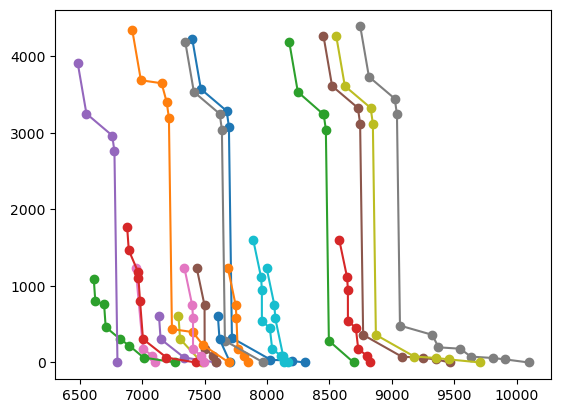

In [141]:
# Get OAs of origin
origin_lsoa = lsoa_info.name
origin_oas = list(set(list(lookup[lookup['LSOA11CD'] == origin_lsoa]['OA11CD'])))

# Get LSOAs in MSOA of destination
destination_msoa = list(set(list(lookup[lookup['MSOA11CD'] == msoas.loc[bike_ods['bicycle'].idxmax()].name]['OA11CD'])))

sp = compute_pareto_fronts(G_c,origin_oas[0])

for oa in destination_msoa:
    print('----- NEXT OA ------')
    print('oa : {}'.format(oa))
    length_risk_curve = sp.get(oa)
    
    if length_risk_curve != None:
    
        if len(length_risk_curve) > 1:
            print('Curve Generated')
            plt.plot(length_risk_curve.keys(), length_risk_curve.values(), marker='o', linestyle='solid')
    
    print()

In [ ]:
#Metrics

#Average Trade Off Rate

#Average number of routes discovered

#Average number of routes discovered normalised by OD distance


In [170]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Example Pareto front data (distance vs. safety)
pareto_front = np.array([
    [1, 10], [2, 8], [3, 7], [4, 5], [5, 4],
    [6, 3], [7, 2], [8, 1], [9, 0.5]
])

# Hypervolume calculation
def hypervolume(pareto_front, reference_point):
    pareto_sorted = pareto_front[np.argsort(pareto_front[:, 0])]
    hv = 0.0
    for i in range(len(pareto_sorted)):
        if i == 0:
            width = reference_point[0] - pareto_sorted[i, 0]
        else:
            width = pareto_sorted[i-1, 0] - pareto_sorted[i, 0]
        height = reference_point[1] - pareto_sorted[i, 1]
        hv += width * height
    return hv

# Spread/diversity calculation
def spread_diversity(pareto_front):
    distances = np.sqrt(np.sum(np.diff(pareto_front, axis=0)**2, axis=1))
    diversity = np.std(distances)
    return diversity

# Convexity (signed area method)
def compute_signed_area(pareto_front):
    hull = ConvexHull(pareto_front)
    hull_area = hull.volume
    pareto_area = np.trapz(pareto_front[:, 1], pareto_front[:, 0])
    signed_area = hull_area - pareto_area
    return signed_area, hull

# Function to compute the trade-off rate
def compute_trade_off_rate(pareto_front):
    trade_off_rates = []
    for i in range(len(pareto_front) - 1):
        delta_x = pareto_front[i+1, 0] - pareto_front[i, 0]
        delta_y = pareto_front[i+1, 1] - pareto_front[i, 1]
        trade_off_rate = delta_y / delta_x
        trade_off_rates.append(trade_off_rate)
    return np.mean(trade_off_rates), trade_off_rates



# Reference point (worse than any point in the front)
reference_point = [10, 11]

# Calculate metrics
hv = hypervolume(pareto_front, reference_point)
diversity = spread_diversity(pareto_front)
signed_area, hull = compute_signed_area(pareto_front)
avg_trade_off_rate, trade_off_rates = compute_trade_off_rate(pareto_front)

print(f"Hypervolume: {hv}")
print(f"Spread/Diversity: {diversity}")
print(f"Signed Area (Convexity): {signed_area}")
print(f"Trade off rate: {avg_trade_off_rate}")

Hypervolume: -48.5
Spread/Diversity: 0.38917096371225696
Signed Area (Convexity): -28.000000000000007
Trade off rate: -1.1875


### Metric 2 - Bikability curve for OD expanded area centred on LSOA

In [142]:
# Coarsen Network
G_c,oas_in_area  = coarsen_network(expanded_geometry,G_expanded_2021,nodes_expanded_2021,oas)

# Get Bikability Curve
G_c=assign_weights(G_c,'Linear')

In [143]:
# Get Origin

# Get OAs of origin
origin_lsoa = lsoa_info.name
origin_oas = list(set(list(lookup[lookup['LSOA11CD'] == origin_lsoa]['OA11CD'])))

# Destinations - x random OA which are not origin
destination_oas = random.sample(oas_in_area, 20)

----- NEXT OA ------
oa : E00045424

----- NEXT OA ------
oa : E00048063
Curve Generated

----- NEXT OA ------
oa : E00048118

----- NEXT OA ------
oa : E00048124
Curve Generated

----- NEXT OA ------
oa : E00048065
Curve Generated

----- NEXT OA ------
oa : E00045490

----- NEXT OA ------
oa : E00048060
Curve Generated

----- NEXT OA ------
oa : E00048123
Curve Generated

----- NEXT OA ------
oa : E00048116
Curve Generated

----- NEXT OA ------
oa : E00045495

----- NEXT OA ------
oa : E00045436

----- NEXT OA ------
oa : E00045435
Curve Generated

----- NEXT OA ------
oa : E00048078
Curve Generated

----- NEXT OA ------
oa : E00048121
Curve Generated

----- NEXT OA ------
oa : E00048126

----- NEXT OA ------
oa : E00048058
Curve Generated

----- NEXT OA ------
oa : E00048117
Curve Generated

----- NEXT OA ------
oa : E00048081
Curve Generated

----- NEXT OA ------
oa : E00048073

----- NEXT OA ------
oa : E00045476
Curve Generated



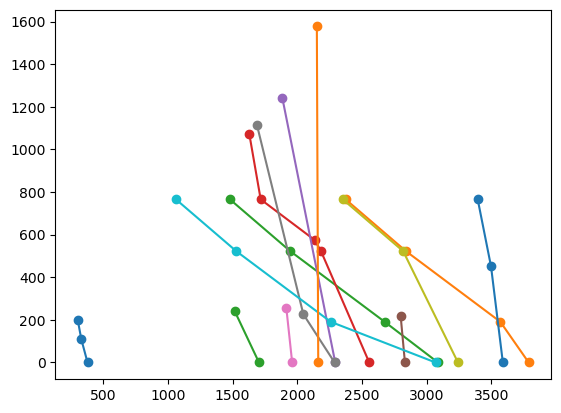

In [144]:
for oa in destination_oas:
    print('----- NEXT OA ------')
    print('oa : {}'.format(oa))
    length_risk_curve = sp.get(oa)
    
    if length_risk_curve != None:
    
        if len(length_risk_curve) > 1:
            print('Curve Generated')
            plt.plot(length_risk_curve.keys(), length_risk_curve.values(), marker='o', linestyle='solid')
    
    print()

### Metric 3 - Bikability curve for OD over larger expanded area centred on LSOA

In [135]:
bbx_expansion_extra = 2
expanded_bbox_extra, expanded_geometry_extra = expand_bbox((lsoa_info['minx'], lsoa_info['miny'], lsoa_info['maxx'], lsoa_info['maxy']), expansion_distance_km=bbx_expansion_extra)

expanded_edges_2021_extra = get_edges_from_geom(expanded_geometry_extra, con, project, 'rn2021_roads')
G_expanded_2021_extra, nodes_expanded_2021_extra, edges_expanded_2021_extra = create_graph(expanded_edges_2021_extra)

/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/chris/miniconda3/envs/ate/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

In [136]:
# Coarsen Network
G_c,oas_in_area  = coarsen_network(expanded_geometry_extra,G_expanded_2021_extra,nodes_expanded_2021_extra,oas)

# Get Bikability Curve
G_c=assign_weights(G_c,'Linear')

In [137]:
# Get Origin

# Get OAs of origin
origin_lsoa = lsoa_info.name
origin_oas = list(set(list(lookup[lookup['LSOA11CD'] == origin_lsoa]['OA11CD'])))

# Destinations - x random OA which are not origin
destination_oas = random.sample(oas_in_area, 30)

----- NEXT OA ------
oa : E00062991
Curve Generated

----- NEXT OA ------
oa : E00063284
Curve Generated

----- NEXT OA ------
oa : E00062979

----- NEXT OA ------
oa : E00062812

----- NEXT OA ------
oa : E00062835

----- NEXT OA ------
oa : E00062967
Curve Generated

----- NEXT OA ------
oa : E00062985
Curve Generated

----- NEXT OA ------
oa : E00063334

----- NEXT OA ------
oa : E00063078

----- NEXT OA ------
oa : E00063346

----- NEXT OA ------
oa : E00062937

----- NEXT OA ------
oa : E00063287
Curve Generated

----- NEXT OA ------
oa : E00063317
Curve Generated

----- NEXT OA ------
oa : E00063156
Curve Generated

----- NEXT OA ------
oa : E00062792

----- NEXT OA ------
oa : E00063347

----- NEXT OA ------
oa : E00063059

----- NEXT OA ------
oa : E00062948
Curve Generated

----- NEXT OA ------
oa : E00062834

----- NEXT OA ------
oa : E00063091

----- NEXT OA ------
oa : E00063055

----- NEXT OA ------
oa : E00063345

----- NEXT OA ------
oa : E00063103
Curve Generated

-----

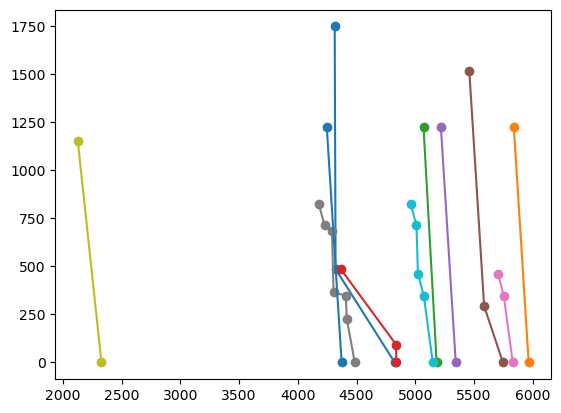

In [138]:
for oa in destination_oas:
    print('----- NEXT OA ------')
    print('oa : {}'.format(oa))
    length_risk_curve = sp.get(oa)
    
    if length_risk_curve != None:
    
        if len(length_risk_curve) > 1:
            print('Curve Generated')
            plt.plot(length_risk_curve.keys(), length_risk_curve.values(), marker='o', linestyle='solid')
    
    print()